# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Cookbook-for-cantera_tools-module" data-toc-modified-id="Cookbook-for-cantera_tools-module-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Cookbook for cantera_tools module</a></div><div class="lev2 toc-item"><a href="#better-names-for-RMG-mechanisms" data-toc-modified-id="better-names-for-RMG-mechanisms-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>better names for RMG mechanisms</a></div><div class="lev2 toc-item"><a href="#reducing-a-mechanism-by-reactions" data-toc-modified-id="reducing-a-mechanism-by-reactions-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>reducing a mechanism by reactions</a></div><div class="lev2 toc-item"><a href="#running-a-simulation" data-toc-modified-id="running-a-simulation-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>running a simulation</a></div><div class="lev3 toc-item"><a href="#run_simulation-example" data-toc-modified-id="run_simulation-example-131"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span><code>run_simulation</code> example</a></div><div class="lev3 toc-item"><a href="#run_simulation_till_conversion-example" data-toc-modified-id="run_simulation_till_conversion-example-132"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span><code>run_simulation_till_conversion</code> example</a></div><div class="lev3 toc-item"><a href="#find_ignition_delay-example" data-toc-modified-id="find_ignition_delay-example-133"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span><code>find_ignition_delay</code> example</a></div><div class="lev3 toc-item"><a href="#set-specific-state-variables-with-time" data-toc-modified-id="set-specific-state-variables-with-time-134"><span class="toc-item-num">1.3.4&nbsp;&nbsp;</span>set specific state variables with time</a></div><div class="lev2 toc-item"><a href="#analyzing-data" data-toc-modified-id="analyzing-data-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>analyzing data</a></div><div class="lev3 toc-item"><a href="#obtaining-reaction-and-species-data" data-toc-modified-id="obtaining-reaction-and-species-data-141"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>obtaining reaction and species data</a></div><div class="lev3 toc-item"><a href="#looking-at-a-list-of-reactions-consuming/producing-a-molecule" data-toc-modified-id="looking-at-a-list-of-reactions-consuming/producing-a-molecule-142"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>looking at a list of reactions consuming/producing a molecule</a></div><div class="lev3 toc-item"><a href="#view-branching-ratio" data-toc-modified-id="view-branching-ratio-143"><span class="toc-item-num">1.4.3&nbsp;&nbsp;</span>view branching ratio</a></div><div class="lev3 toc-item"><a href="#creating-flux-diagrams" data-toc-modified-id="creating-flux-diagrams-144"><span class="toc-item-num">1.4.4&nbsp;&nbsp;</span>creating flux diagrams</a></div>

# Cookbook for cantera_tools module

This notebook describes some of the methods in this package and how they can be used.

In [1]:
import cantera_tools as ctt
import numpy as np
from scipy import integrate
import cantera as ct
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## better names for RMG mechanisms

Many RMG models have poorly-named species, due in part to restrictions of CHEMKIN names. Cantera have fewer restrictions, so mechanisms produced with it can have more understandable names. This example converts an RMG CHEMKIN file to a Cantera file which uses SMILES to names species.

This method will place an `input_nicely_named.cti` and a `species_dictionary_nicely_named.txt` into the folder specified in the method

In [2]:
ctt.obtain_cti_file_nicely_named('cookbook_files/',original_ck_file='chem.inp')

Using Theano backend.


## reducing a mechanism by reactions
The modules can create a reduced mechanism given a list of desired reaction strings, using how cantera represents the reaction strings (this can be found by `solution.reaction_equations()`). It will remove any unused species as well.

In [3]:
model_link = 'cookbook_files/model.cti'

desired_reactions = ['CH3OH + O2 <=> CH2OH(29) + HO2(12)',
 'C3H8 + O2 <=> C3H7(61) + HO2(12)',
 'C3H8 + O2 <=> C3H7(60) + HO2(12)',
 'CH3OH + OH(10) <=> CH2OH(29) + H2O(11)',
 'C3H8 + OH(10) <=> C3H7(60) + H2O(11)',
 'C3H8 + OH(10) <=> C3H7(61) + H2O(11)',
 'CH3OH + HO2(12) <=> CH2OH(29) + H2O2(13)',
 'C3H8 + HO2(12) <=> C3H7(61) + H2O2(13)',
 'C3H8 + HO2(12) <=> C3H7(60) + H2O2(13)',
 'C3H7(60) + O2 <=> C3H7O2(78)',
 'C3H7(61) + O2 <=> C3H7O2(80)',]

# make the reduced mechanism using the full mechanism `.cti` file.
solution_reduced = ctt.create_mechanism(model_link, kept_reaction_equations=desired_reactions)

# NOTE: this cantera Solution object can now be used like any other

## running a simulation

Simulations can be run in the following ways:

1. `run_simulation` - you give the method times which you want data saved, and it saves data at each time.
2. `run_simulation_till_conversion` - this method will run a simulation until the specified conversion is reached for a target species.
3. `find_ignition_delay` - you give this method the initial conditions and it outputs the ignition delay determined by the maximum of $\frac{dT}{dt}$, as well as simulation data given every so many iterator steps.


These methods currently work for constant temperature and pressure or adiabatic constant volume. 


It's also possible to adapt these methods to your specific situation. If you think your adaption will be useful for others, consider talking with the author (posting a issue or in person) or just making a pull request.

### `run_simulation` example

In [4]:
model_link = 'cookbook_files/model.cti'

# creates the cantera Solution object
solution = ctt.create_mechanism(model_link)

#initial mole fractions
mole_fractions = {'N2':5, 'O2':1, 'C3H8': 0.3}

# set initial conditions of solution in kelvin pascals and mole fractions
conditions = 800, 10**6, mole_fractions
solution.TPX = conditions
# store 100 times between 10^-8s and 1s, with an initial point at t=0
times = np.logspace(-8,0,num=100)
times = np.insert(times,0,0)

# run the simulation
outputs = ctt.run_simulation(solution, times,
                                      condition_type = 'constant-temperature-and-pressure',
                                      output_reactions = True,
                                      output_directional_reactions = True,
                                      output_rop_roc=True)

# you can combine outputs how you would like with pd.concat
result = pd.concat([outputs['conditions'], outputs['species'], outputs['directional_reactions']], axis = 'columns')

# data can be saved to avoid rerunning the simulation for data analysis (in most cases). these can be loaded using pandas.from_pickle() and pandas.from_csv()
result.to_pickle('cookbook_files/{}.pic'.format('run_simulation_example'))
result.to_csv('cookbook_files/{}.csv'.format('run_simulation_example'))

### `run_simulation_till_conversion` example

In [5]:
model_link = 'cookbook_files/model.cti'

# creates the cantera Solution object
solution = ctt.create_mechanism(model_link)

# finds initial mole fraction for a fuel-air ratio 
mole_fractions = ctt.get_initial_mole_fractions(stoich_ratio = 1,
                                                fuel_mole_ratios=[1],
                                               oxygen_per_fuel_at_stoich_list = [5],
                                               fuels = ['C3H8'])

# set initial conditions of solution in kelvin pascals and mole fractions
conditions = 950, 10**6, mole_fractions
solution.TPX = conditions
# run simulation
output_till_conversion = ctt.run_simulation_till_conversion(solution, 
                                             species='C3H8',
                                             conversion=0.5,
                                             condition_type = 'constant-temperature-and-pressure',
                                             output_species = True,
                                             output_reactions = True,
                                             output_directional_reactions = True,
                                             output_rop_roc = True,
                                             skip_data = 25)

### `find_ignition_delay` example

In [6]:
model_link = 'cookbook_files/model.cti'

# creates the cantera Solution object
solution = ctt.create_mechanism(model_link)

# finds initial mole fraction for a fuel-air ratio of 1 with 30%/70% methanol/propane blend
# for non-combustion conditions, this can be replaced by a dictionary of values {'CH3OH': 0.3, 'C3H8':0.7}
mole_fractions = ctt.get_initial_mole_fractions(stoich_ratio = 1,
                                               fuel_mole_ratios = [.3,.7],
                                               oxygen_per_fuel_at_stoich_list = [1.5,5],
                                               fuels = ['CH3OH','C3H8'])

# set initial conditions of solution in kelvin pascals and mole fractions
conditions = 750, 10**6, mole_fractions

# run simulation
outputs = ctt.find_ignition_delay(solution, conditions,
                                               output_profile = True,
                                               output_directional_reactions = True,
                                               skip_data = 1000)

# obtain the ignition delays
ignition_delay = outputs['ignition_delay']

### set specific state variables with time
Specific state variables (like temperature) can be set across a simulation.
To use this, change the `condition_type` to the string that describes the
situation (list of acceptable strings is described in the docstring of `run_simulation`.

Typically you also need to supply a list of the state variable to change which corresponds with the times in the `times` variable. 

In [7]:
model_link = 'cookbook_files/model.cti'

# creates the cantera Solution object
solution = ctt.create_mechanism(model_link)

#initial mole fractions
mole_fractions = {'N2':5, 'O2':1, 'C3H8': 0.3}

# set initial conditions of solution in kelvin pascals and mole fractions
conditions = 800, 10**6, mole_fractions
solution.TPX = conditions
# store 100 times between 10^-8s and 0.01s, with an initial point at t=0
times = np.logspace(-8,-2,num=100)
times = np.insert(times,0,0)
# set a linear ramp temperature from 800 to 1000 at 1e-5s followed by constant temperature
ramp_temperatures = 800 + 2000000 * times[:50]
constant_temperatures = np.ones(51) * 1000
temperatures = np.concatenate((ramp_temperatures,constant_temperatures))
# run the simulation
outputs = ctt.run_simulation(solution, times,
                                      condition_type = 'specified-temperature-constant-volume',
                                      output_reactions = True,
                                      output_directional_reactions = True,
                                      output_rop_roc= False,
                                      temperature_values = temperatures)

## analyzing data
### obtaining reaction and species data

In [8]:
# this outputs a dataframe of just species
species = outputs['species']
reactions = outputs['net_reactions']
forward_and_reverse_reactions = outputs['directional_reactions']
net_observables = outputs['conditions']

# obtain reactions with a specific molecule
reactions_with_propane = ctt.find_reactions(df=reactions,
                                             solution=solution,
                                             species = 'C3H8')

### viewing species concentrations
species concentration with time can be accessed from the dataframe contained in `outputs['species']`

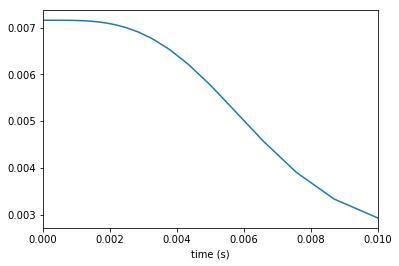

In [9]:
species['C3H8'].plot()

### view reactions consuming/producing a molecule

Negative values indicate that the reaction consumes the molecule. Positive values indicate that the reaction produces the molecule.

In [10]:
propane_production = ctt.consumption_pathways(df=reactions,
                                           solution=solution,
                                           species = 'C3H8')

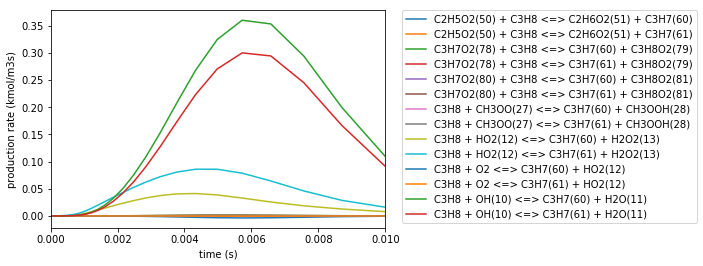

In [11]:
f, ax = plt.subplots()
reactions_with_propane.plot.line(ax=ax)
import plot_tools as ptt
ptt.place_legend_outside_plot(axis=ax)
ax.set_ylabel('production rate (kmol/m3s)')

### view branching ratio

In [12]:
# this outputs the branching ratio of propane
branching = ctt.branching_ratios(df=reactions,
                                 solution=solution,
                                 compound='C3H8')

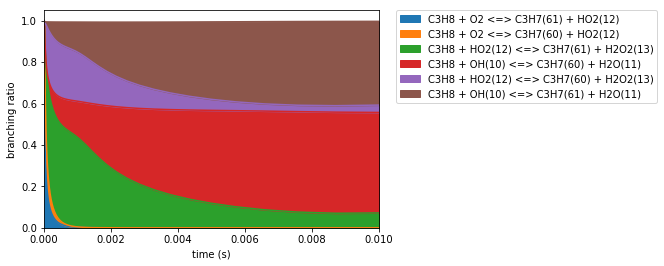

In [13]:
f, ax = plt.subplots()
# plot only the top 6 branching ratios
branching.iloc[:,:6].plot.area(ax=ax)
import plot_tools as ptt
ptt.place_legend_outside_plot(axis=ax)
ax.set_ylabel('branching ratio')

### creating flux diagrams

The method `save_flux_diagrams`, shown below, runs a simulation saving the diagrams at various times. The method `save_flux_diagram` can be integrated into another simulation solver.

In [14]:
model_link = 'cookbook_files/model.cti'

solution = ctt.create_mechanism(model_link)

mole_fractions = {'N2':5, 'O2':1, 'C3H8': 0.3}

conditions = 800, 10**6, mole_fractions
solution.TPX = conditions

#only specify the times you want a flux diagram at
times = np.logspace(-8,0,num=3)

# run the simulation & create flux diagrams
outputs = ctt.save_flux_diagrams(solution, times,
                                 condition_type = 'constant-temperature-and-pressure',
                                 path='cookbook_files/',
                                 filename='cookbook_fluxes',
                                 filetype = 'svg',
                                 element='C')

Wrote graphviz output file to 'cookbook_files/cookbook_fluxes_1.00e-08s.svg'.
Wrote graphviz output file to 'cookbook_files/cookbook_fluxes_1.00e-04s.svg'.
Wrote graphviz output file to 'cookbook_files/cookbook_fluxes_1.00e+00s.svg'.
